### Preamble
- This notebook is overviews the provided API for using GPflow-based models
- Available models inherit from the following base class (shown in simplified form here):
```python
class PathwiseGPModel(GPModel):
    def __init__(self, *args, paths: AbstractSampler = None, **kwargs):
        super().__init__(*args, **kwargs)
        self._paths = paths
 
    @abstractmethod
    def generate_paths(self, *args, **kwargs) -> AbstractSampler:
        raise NotImplementedError

    def predict_f_samples(self, Xnew: TensorLike):
        return self.paths(Xnew, **kwargs)
```
- These classes act **identical** to their GPflow counterparts, save for `predict_f_samples`
- Below, we demonstrate some common usage patterns for the basic `<PathwiseGPR>` model class

In [1]:
import numpy as np
import tensorflow as tf

from gpflow.config import default_float as floatx
from gpflow.kernels import Matern52
from gpflow_sampling.models import PathwiseGPR
from gpflow_sampling.sampling.updates import cg as cg_update

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', dpi=256)
plt.rc('font', family='serif', size=12)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'''
       \usepackage{amsmath,amsfonts}
       \renewcommand{\v}[1]{\boldsymbol{#1}}''')

In [3]:
tf.random.set_seed(1)

### Generate toy data

In [4]:
kernel = Matern52(lengthscales=0.1)
noise2 = 1e-3  # measurement noise variance

xmin = 0.15  # range over which we observe
xmax = 0.50  # the behavior of a function $f$
X = tf.convert_to_tensor(np.linspace(xmin, xmax, 1024)[:, None])

K = kernel(X, full_cov=True)
L = tf.linalg.cholesky(tf.linalg.set_diag(K, tf.linalg.diag_part(K) + noise2))
y = L @ tf.random.normal([len(X), 1], dtype=floatx())
y -= tf.reduce_mean(y)  # for simplicity, center the data

### Create model and predict moments

In [5]:
model = PathwiseGPR(data=(X, y), kernel=kernel, noise_variance=noise2)
Xnew = np.linspace(0, 1, 1024)[:, None]
mu, sigma2 = map(tf.squeeze, model.predict_f(Xnew, full_cov=False))

### Sampling behavior
- The default behavior is to throw an error if `self._paths is None`

In [6]:
try:
    f = tf.squeeze(model.predict_f_samples(Xnew))
except RuntimeError as err:
    print(f"ERROR: {err}")

ERROR: Paths were not initialized.


- The class's `generate_paths` method should return function draws (i.e. paths)
- If keyword argument `prior=None`, prior samples are constructed using `num_bases` Random Fourier Features (RFF)

In [7]:
paths = model.generate_paths(num_samples=32, num_bases=1024)  # returned paths are deterministic!
f_orig = paths(Xnew)
print(f"shape(f) = {f_orig.shape}")

shape(f) = (32, 1024, 1)


- We may also evaluate each path for different choices of `X` by specifying a `sample_axis`

In [8]:
Xnew_tiled = tf.tile(Xnew[None], paths.sample_shape + [1, 1])
f_pathwise = paths(Xnew_tiled, sample_axis=0)
print(f"shape(f_pathwise) = {f_pathwise.shape}")

shape(f_pathwise) = (32, 1024, 1)


- Instance-level paths can be assigned using `model.set_paths(paths)` or `model.set_temporary_paths(paths)`
- We often prefer to use `self.temporary_paths(...)`, which helps to ensure terms are automatically differentiable

In [9]:
model.set_paths(paths)
print(f"[Before] predict_f_samples(Xnew) == paths(Xnew)"
      f" = {tf.reduce_all(model.predict_f_samples(Xnew) == f_orig)}")

with tf.GradientTape() as tape:
    with model.temporary_paths(num_samples=32, num_bases=1024) as temp_paths:
        f_temp = model.predict_f_samples(Xnew)
        
        print(f"[During] predict_f_samples(Xnew) == paths(Xnew)"
              f" = {tf.reduce_all(f_temp == f_orig)}")

        _, fvar = tf.nn.moments(f_temp, axes=0)
        loss = tf.reduce_mean(fvar)
    
    grads = tape.gradient(loss, model.trainable_variables)
    for g in grads:
        assert g is not None
    
print(f"[After] predict_f_samples(Xnew) == paths(Xnew)"
      f" = {tf.reduce_all(model.predict_f_samples(Xnew) == f_orig)}")

[Before] predict_f_samples(Xnew) == paths(Xnew) = True
[During] predict_f_samples(Xnew) == paths(Xnew) = False
[After] predict_f_samples(Xnew) == paths(Xnew) = True


### Visualize
- For fun, let's use preconditioned CG to approximately solve for the update.

In [10]:
with model.temporary_paths(num_samples=10000, 
                           num_bases=1024,
                           update_rule=cg_update):

    f_plot = tf.squeeze(model.predict_f_samples(Xnew))

Instructions for updating:
Do not call `graph_parents`.


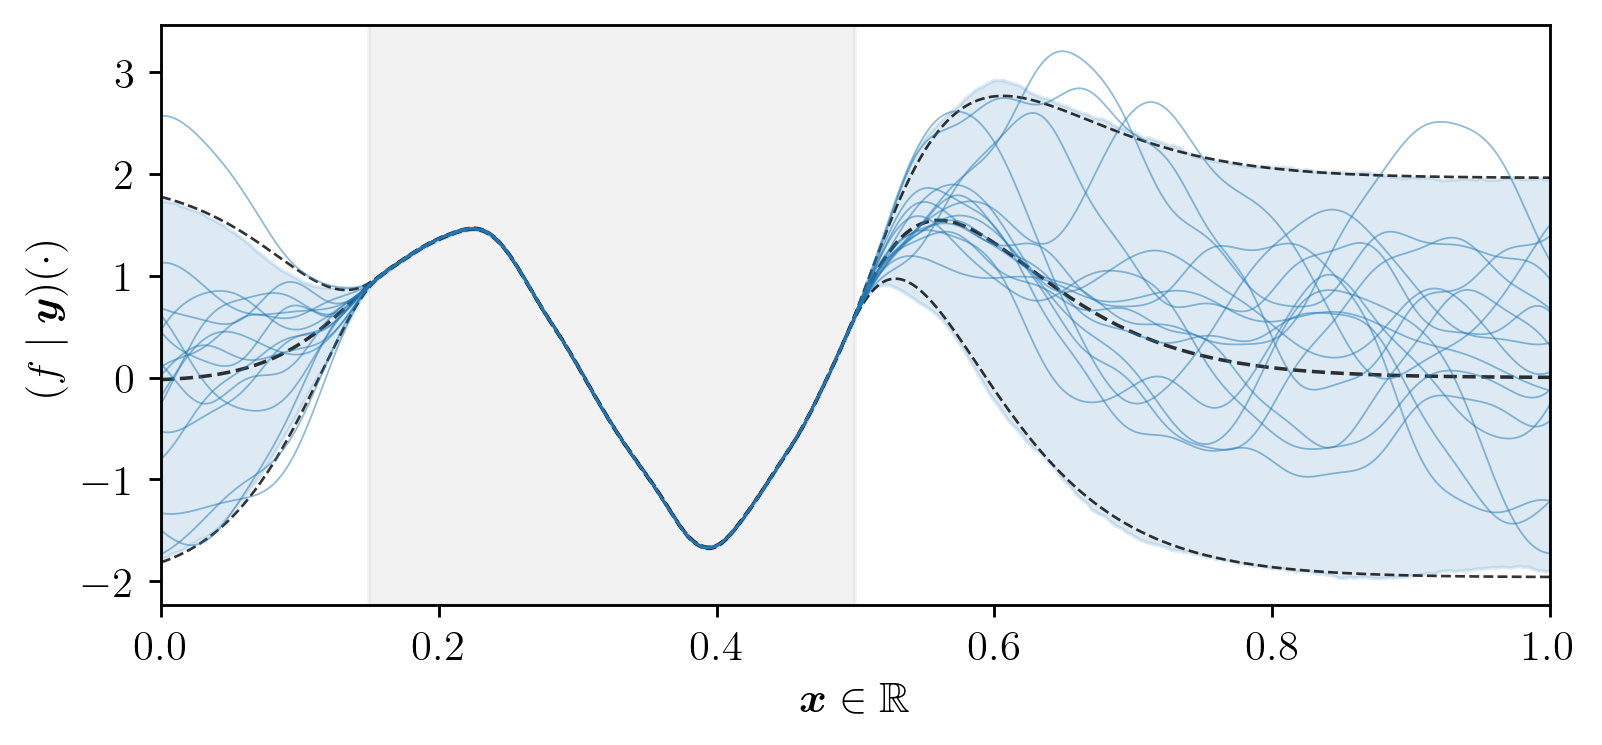

In [11]:
fig, ax = plt.subplots(figsize=(7, 3))
lower = tf.cast(0.025, floatx())
upper = tf.cast(0.975, floatx())

# Show gold-standard quantiles
ax.plot(Xnew, mu , '--k', linewidth=1.0, alpha=0.8)
ax.plot(Xnew, mu + tf.math.ndtri(lower) * tf.sqrt(sigma2), '--k', linewidth=0.75, alpha=0.8)
ax.plot(Xnew, mu + tf.math.ndtri(upper) * tf.sqrt(sigma2), '--k', linewidth=0.75, alpha=0.8)

# Show empirical quantiles
ax.fill_between(Xnew[:, 0], 
                *np.quantile(f_plot, q=(lower, upper), axis=0), 
                color='tab:blue', 
                alpha=0.15)

# Plot some sample paths
for f in f_plot[:16]:
    ax.plot(Xnew, f, alpha=0.5, linewidth=0.5, color='tab:blue')

# Indicate where the training data is located
ylim = ax.get_ylim()
ax.fill_between([xmin, xmax], *ylim, zorder=0, color='silver', alpha=0.2)

_ = ax.set_ylim(ylim)
_ = ax.set_ylabel(r'$(f \mid \v{y})(\cdot)$')
_ = ax.set_xlim(0, 1)
_ = ax.set_xlabel(r'$\v{x} \in \mathbb{R}$')